<p style="font-family: 'Courier New', Courier, monospace; font-size: 50px; font-weight: bold; color: blue;  text-align: center;">
  LoRaWAN Path Loss Measurements in an Indoor Setting: EXPLORATORY DATA ANALYSIS
</p>

<div style="text-align: center;">
    <img src="lorawan.png" alt="LoRaWAN">
    <div style="text-align: right;">Photo Credit: <a href="https://onesight.solutions/wp-content/uploads/2023/10/LoraWAN-Test-Kit-Sales-Tech-Rev-2.pdf">Here</a></div>
</div>


In [4]:
# Libraries/Packages Used:
import os                                  # For accessing environment variables.
from dotenv import load_dotenv             # To load environment variables from an .env file.
import pandas as pd                        # For data manipulation and analysis.
import numpy as np                         # For numerical computations and handling arrays.
import math                                # For mathematical functions.
from datetime import datetime, timedelta   # For handling date and time operations.
import itertools                           # To cycle through iterables.
import matplotlib.gridspec as gridspec     # For grid layout management.
from itertools import cycle                # To cycle through specific iterables like colors.
import matplotlib.pyplot as plt            # For creating static visualizations.
from matplotlib.lines import Line2D        # For custom lines in plots.
from collections import OrderedDict        # For maintaining order in unique legend entries
import seaborn as sns                      # For statistical data visualization based on matplotlib.
import plotly.graph_objs as go             # For creating interactive visualizations.
from plotly.subplots import make_subplots  # For creating interactive subplots.

import plotly.io as pio
pio.renderers.default = 'jupyterlab'

In [5]:
# Read data from a local CSV file
new_df = pd.read_csv('../all_data_files/combined_measurements_data.csv', low_memory=False)

# Print the info about the combined DataFrame
print("\nInfo of Combined DataFrame:\n")
new_df.info()


Info of Combined DataFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 924423 entries, 0 to 924422
Data columns (total 82 columns):
 #   Column                                                   Non-Null Count   Dtype  
---  ------                                                   --------------   -----  
 0   time                                                     924423 non-null  object 
 1   correlation_ids_0                                        924423 non-null  object 
 2   device_id                                                924423 non-null  object 
 3   end_device_ids_application_ids_application_id            924423 non-null  object 
 4   end_device_ids_dev_addr                                  924423 non-null  object 
 5   end_device_ids_dev_eui                                   924423 non-null  object 
 6   end_device_ids_device_id                                 924423 non-null  object 
 7   end_device_ids_join_eui                                  924423 non-nul

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
  Creating the assorted/aggregated measurements Dataframe, i.e. keeping important columns, mapping necessary info too.
</p>

In [7]:
# Columns to keep and their new names for better readability
columns_to_keep = {
    'time': 'time',
    'end_device_ids_device_id': 'device_id',
    'uplink_message_decoded_payload_co2': 'co2',
    'uplink_message_decoded_payload_humidity': 'humidity',
    'uplink_message_decoded_payload_pm25': 'pm25',
    'uplink_message_decoded_payload_pressure': 'pressure',
    'uplink_message_decoded_payload_temperature': 'temperature',
    'uplink_message_rx_metadata_0_rssi': 'rssi',
    'uplink_message_rx_metadata_0_snr': 'snr',
    'uplink_message_settings_data_rate_lora_spreading_factor': 'SF',
    'uplink_message_settings_frequency': 'frequency',
    'uplink_message_f_cnt': 'f_count',
    'uplink_message_decoded_payload_packetCount' : 'p_count',
    'uplink_message_consumed_airtime' : 'toa'
}

# Select and rename columns to keep the dataset clean
cleaned_df = new_df[list(columns_to_keep.keys())].rename(columns=columns_to_keep)

# Add a 'distance' column based on device_id values
distance_map = {
    'pilotdevice'  : 10,
    'pilotdevice01': 8,
    'pilotdevice02': 23,
    'pilotdevice03': 18,
    'pilotdevice04': 37,
    'pilotdevice05': 40
}

# Map the distances to the devices
cleaned_df['distance'] = cleaned_df['device_id'].map(distance_map)

# Define the mapping for c_walls and w_walls
wall_counts_map = {
    'pilotdevice': (0, 0),
    'pilotdevice01': (1, 0),
    'pilotdevice02': (0, 2),
    'pilotdevice03': (1, 2),
    'pilotdevice04': (0, 5),
    'pilotdevice05': (2, 2)
}

# Map the c_walls and w_walls columns using the provided tuple mapping
cleaned_df[['c_walls', 'w_walls']] = cleaned_df['device_id'].map(wall_counts_map).apply(pd.Series)

# Shorten the device names for easier reference
device_name_map = {
    'pilotdevice'  : 'ED0',
    'pilotdevice01': 'ED1',
    'pilotdevice02': 'ED2',
    'pilotdevice03': 'ED3',
    'pilotdevice04': 'ED4',
    'pilotdevice05': 'ED5'
}

# Apply the name mapping so that devices now use shorter names
cleaned_df['device_id'] = cleaned_df['device_id'].map(device_name_map)

# Convert the frequency column to numeric (handling any errors) and convert to MHz
cleaned_df['frequency'] = pd.to_numeric(cleaned_df['frequency'], errors='coerce')
cleaned_df['frequency'] = cleaned_df['frequency'] / 1e6  # Hz to MHz

# Clean up the 'toa' column by removing the 's' at the end and converting to float
cleaned_df['toa'] = cleaned_df['toa'].str.rstrip('s').astype(float)

# Adding the 'experimental_PL' column based on the provided constants and formula
cleaned_df = cleaned_df.assign(
    exp_pl = 14 - 1 + 1.4 + 3 - cleaned_df['rssi']  
    # Using the exact values: tx_p=14, tx_cl=1, tx_ag=1.4, rx_ag=3, tx_cl=0
)

# Calculate Noise Power (n_power) in dBm
cleaned_df = cleaned_df.assign(
    n_power = cleaned_df['rssi'] - 10 * np.log10(np.power(10, cleaned_df['snr'] / 10) + 1)
)

# Calculate Effective Signal Power (esp) in dBm
cleaned_df = cleaned_df.assign(
    esp = cleaned_df['n_power'] + cleaned_df['snr']
)

#  'SF' from float to int
cleaned_df['SF'] = cleaned_df['SF'].astype('int64')

# Save the cleaned and aggregated data to a CSV file 
cleaned_df.to_csv('../all_data_files/aggregated_measurements_data.csv', index=False)

# Display DataFrame information to confirm everything
cleaned_df.info()
cleaned_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 924423 entries, 0 to 924422
Data columns (total 20 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   time         924423 non-null  object 
 1   device_id    924423 non-null  object 
 2   co2          924423 non-null  float64
 3   humidity     924423 non-null  float64
 4   pm25         924423 non-null  float64
 5   pressure     924423 non-null  float64
 6   temperature  924423 non-null  float64
 7   rssi         924423 non-null  float64
 8   snr          923631 non-null  float64
 9   SF           924423 non-null  int64  
 10  frequency    924423 non-null  float64
 11  f_count      924410 non-null  float64
 12  p_count      924423 non-null  float64
 13  toa          924423 non-null  float64
 14  distance     924423 non-null  int64  
 15  c_walls      924423 non-null  int64  
 16  w_walls      924423 non-null  int64  
 17  exp_pl       924423 non-null  float64
 18  n_power      923631 non-

time device_id    co2  humidity  pm25  \
0       2024-09-26 11:01:08.336258+00:00       ED0  541.0     49.34  0.46   
1       2024-09-26 11:02:08.387851+00:00       ED0  539.0     49.34  0.39   
2       2024-09-26 11:03:08.309590+00:00       ED0  540.0     49.33  0.80   
3       2024-09-26 11:04:08.368448+00:00       ED0  537.0     49.28  0.71   
4       2024-09-26 11:05:08.405529+00:00       ED0  537.0     49.34  0.56   
...                                  ...       ...    ...       ...   ...   
924418  2025-01-27 10:00:39.449298+00:00       ED5  604.0     42.51  0.66   
924419  2025-01-27 10:01:39.287912+00:00       ED5  615.0     42.58  0.72   
924420  2025-01-27 10:02:47.337739+00:00       ED5  605.0     42.53  0.90   
924421  2025-01-27 10:03:39.393844+00:00       ED5  613.0     42.53  0.80   
924422  2025-01-27 10:04:39.433544+00:00       ED5  622.0     42.49  0.57   

        pressure  temperature  rssi   snr  SF  frequency   f_count   p_count  \
0         299.70        24.57 -52.0  13.2   9      868.1      81.0     108.0   
1         299.69        24.57 -48.0   8.5   9      867.5      82.0     109.0   
2         299.77        24.59 -48.0  12.8   8      867.3      83.0     110.0   
3         299.70        24.62 -48.0   8.0   8      868.5      84.0     111.0   
4         299.69        24.63 -49.0  11.0   8      867.9      85.0     112.0   
...          ...          ...   ...   ...  ..        ...       ...       ...   
924418    298.81        20.12 -85.0   9.8  10      868.3  124913.0  136514.0   
924419    298.84        20.12 -98.0  11.0   9      867.7  124914.0  136515.0   
924420    298.88        20.14 -93.0  10.2   9      868.3  124915.0  136516.0   
924421    298.98        20.14 -90.0  11.0   9      868.1  124916.0  136517.0   
924422    298.95        20.16 -93.0  10.8   9      867.9  124917.0  136518.0   

             toa  distance  c_walls  w_walls  exp_pl     n_power        esp  
0       0.246784        10        0        0    69.4  -65.403045 -52.203045  
1       0.246784        10        0        0    65.4  -57.073822 -48.573822  
2       0.133632        10        0        0    65.4  -61.022142 -48.222142  
3       0.133632        10        0        0    65.4  -56.638920 -48.638920  
4       0.133632        10        0        0    66.4  -60.331956 -49.331956  
...          ...       ...      ...      ...     ...         ...        ...  
924418  0.452608        40        2        2   102.4  -95.232494 -85.432494  
924419  0.246784        40        2        2   115.4 -109.331956 -98.331956  
924420  0.246784        40        2        2   110.4 -103.596121 -93.396121  
924421  0.246784        40        2        2   107.4 -101.331956 -90.331956  
924422  0.246784        40        2        2   110.4 -104.146992 -93.346992  

[924423 rows x 20 columns]

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
  Checking (abnormal) Anomalies with BOX PLOTS
</p>

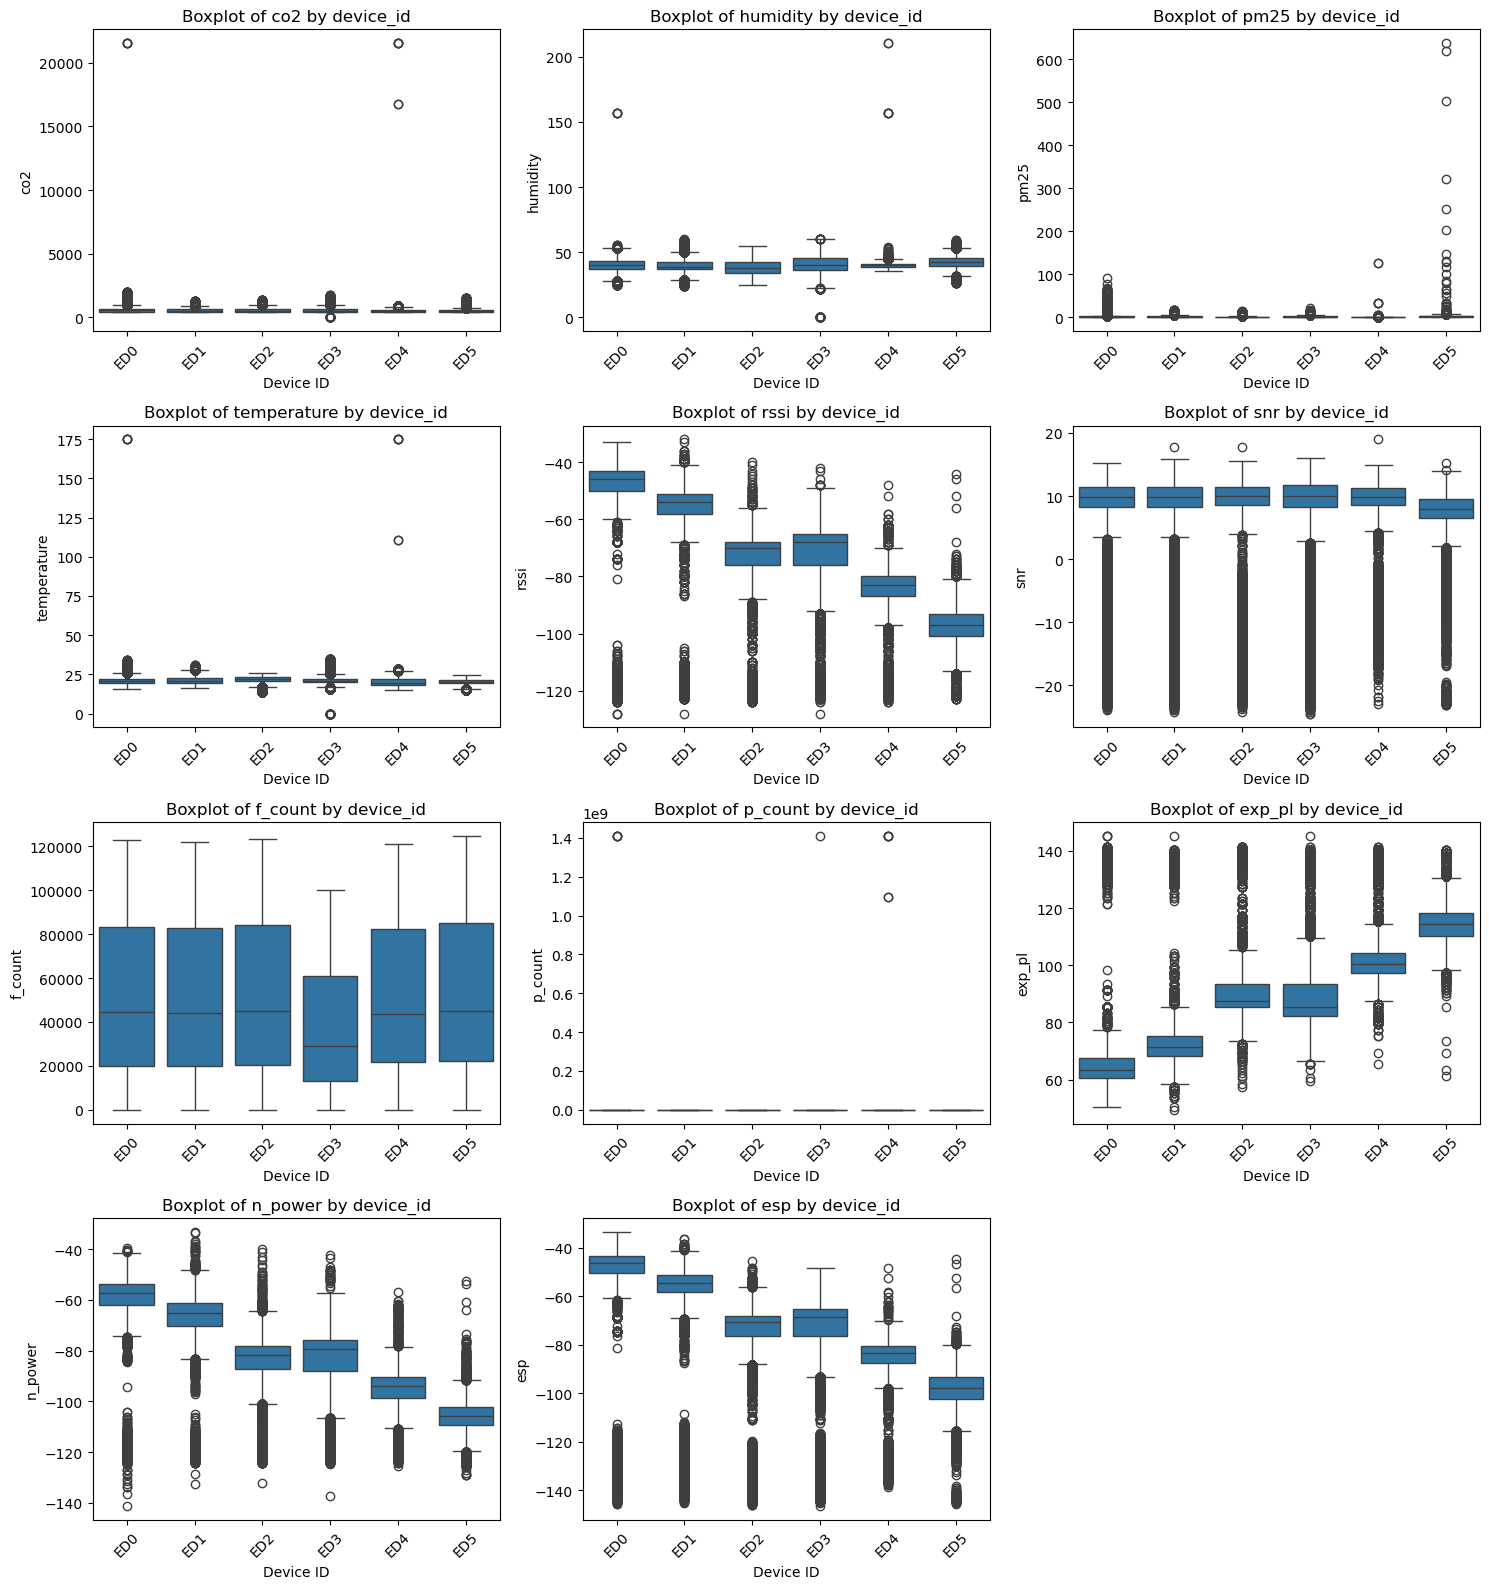

In [9]:
# Columns to exclude
exclude_cols = ['c_walls', 'w_walls', 'frequency', 'SF', 'toa', 'distance', 'pressure']

# Select numeric columns excluding 'f_count' and 'p_count'
numeric_cols = cleaned_df.select_dtypes(include=['float64', 'int64']).columns.drop(exclude_cols)

# Define the desired order for device_id
desired_order = ['ED0', 'ED1', 'ED2', 'ED3', 'ED4', 'ED5']

# Ensure 'device_id' is a categorical type with the specified order
cleaned_df.loc[:, 'device_id'] = pd.Categorical(cleaned_df['device_id'], categories=desired_order, ordered=True)

# Determine the number of plots
num_vars = len(numeric_cols)
cols = 3  # Number of columns in the subplot grid
rows = math.ceil(num_vars / cols)

# Set the overall figure size
plt.figure(figsize=(cols * 5, rows * 4))

# Iterate over each numeric column and create a subplot
for idx, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, cols, idx)
    sns.boxplot(x='device_id', y=col, data=cleaned_df, order=desired_order)
    plt.title(f'Boxplot of {col} by device_id')
    plt.xlabel('Device ID')
    plt.ylabel(col)
    plt.xticks(rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
  Packet Delivery Ratio (PDR)
</p>

In [11]:
# Remove rows with a p_count above 2M ('abnormal outlier')
cleaned_df = cleaned_df[~(cleaned_df['p_count'] > 2000000)]

# Grouping data by device_id
grouped = cleaned_df.groupby('device_id')

# Calculating the total sent and received packets
pdr_table = grouped.agg(
    total_sent_packets=('p_count', 'max'),
    received_packets=('f_count', 'max')
)

# Calculating the PDR
pdr_table['PDR (%)'] = (pdr_table['received_packets'] / pdr_table['total_sent_packets']) * 100

# Displaying the result as a table
pdr_table

total_sent_packets  received_packets    PDR (%)
device_id                                                 
ED0                  136483.0          122794.0  89.970179
ED1                  136471.0          122031.0  89.418997
ED2                  136494.0          123402.0  90.408370
ED3                  111924.0          100166.0  89.494657
ED4                  136461.0          121103.0  88.745502
ED5                  136518.0          124917.0  91.502219

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
  Channel Usage Transmissions Confirmation / Check
</p>

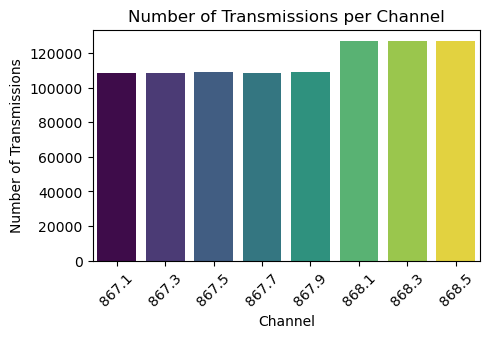

In [13]:
# Count transmissions per channel
channel_counts = cleaned_df['frequency'].value_counts().sort_index()

# Plotting the distribution
plt.figure(figsize=(5, 3))
sns.barplot(
    x=channel_counts.index,
    y=channel_counts.values,
    hue=channel_counts.index,      # 'x' to 'hue'
    palette='viridis',
    dodge=False,                  
    legend=False              
)
plt.title('Number of Transmissions per Channel')
plt.xlabel('Channel')
plt.ylabel('Number of Transmissions')
plt.xticks(rotation=45)
plt.show()

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
  Visual Dataframe Cleaning
</p>

In [15]:
# Remove rows with a temperature above 80
cleaned_df = cleaned_df[~(cleaned_df['temperature'] > 80)]

# Remove rows with humidity below 100
cleaned_df = cleaned_df[~(cleaned_df['humidity'] > 100)]

# Remove rows with a CO2 above 5000
cleaned_df = cleaned_df[~(cleaned_df['co2'] > 5000)]

# Remove rows with a CO2 = 0
cleaned_df = cleaned_df[~(cleaned_df['co2'] == 0)]

# Save all data to csv
cleaned_df.to_csv('../all_data_files/visually_cleaned_df.csv', index=False)

# Display the cleaned Dataframe Info
print("\nInfo of Combined DataFrame:\n")
cleaned_df.info()


Info of Combined DataFrame:

<class 'pandas.core.frame.DataFrame'>
Index: 924372 entries, 0 to 924422
Data columns (total 20 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   time         924372 non-null  object 
 1   device_id    924372 non-null  object 
 2   co2          924372 non-null  float64
 3   humidity     924372 non-null  float64
 4   pm25         924372 non-null  float64
 5   pressure     924372 non-null  float64
 6   temperature  924372 non-null  float64
 7   rssi         924372 non-null  float64
 8   snr          923580 non-null  float64
 9   SF           924372 non-null  int64  
 10  frequency    924372 non-null  float64
 11  f_count      924359 non-null  float64
 12  p_count      924372 non-null  float64
 13  toa          924372 non-null  float64
 14  distance     924372 non-null  int64  
 15  c_walls      924372 non-null  int64  
 16  w_walls      924372 non-null  int64  
 17  exp_pl       924372 non-null  float64
 18 

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
   BOX PLOTS after physical elimination of 'abnormal' anomalies
</p>

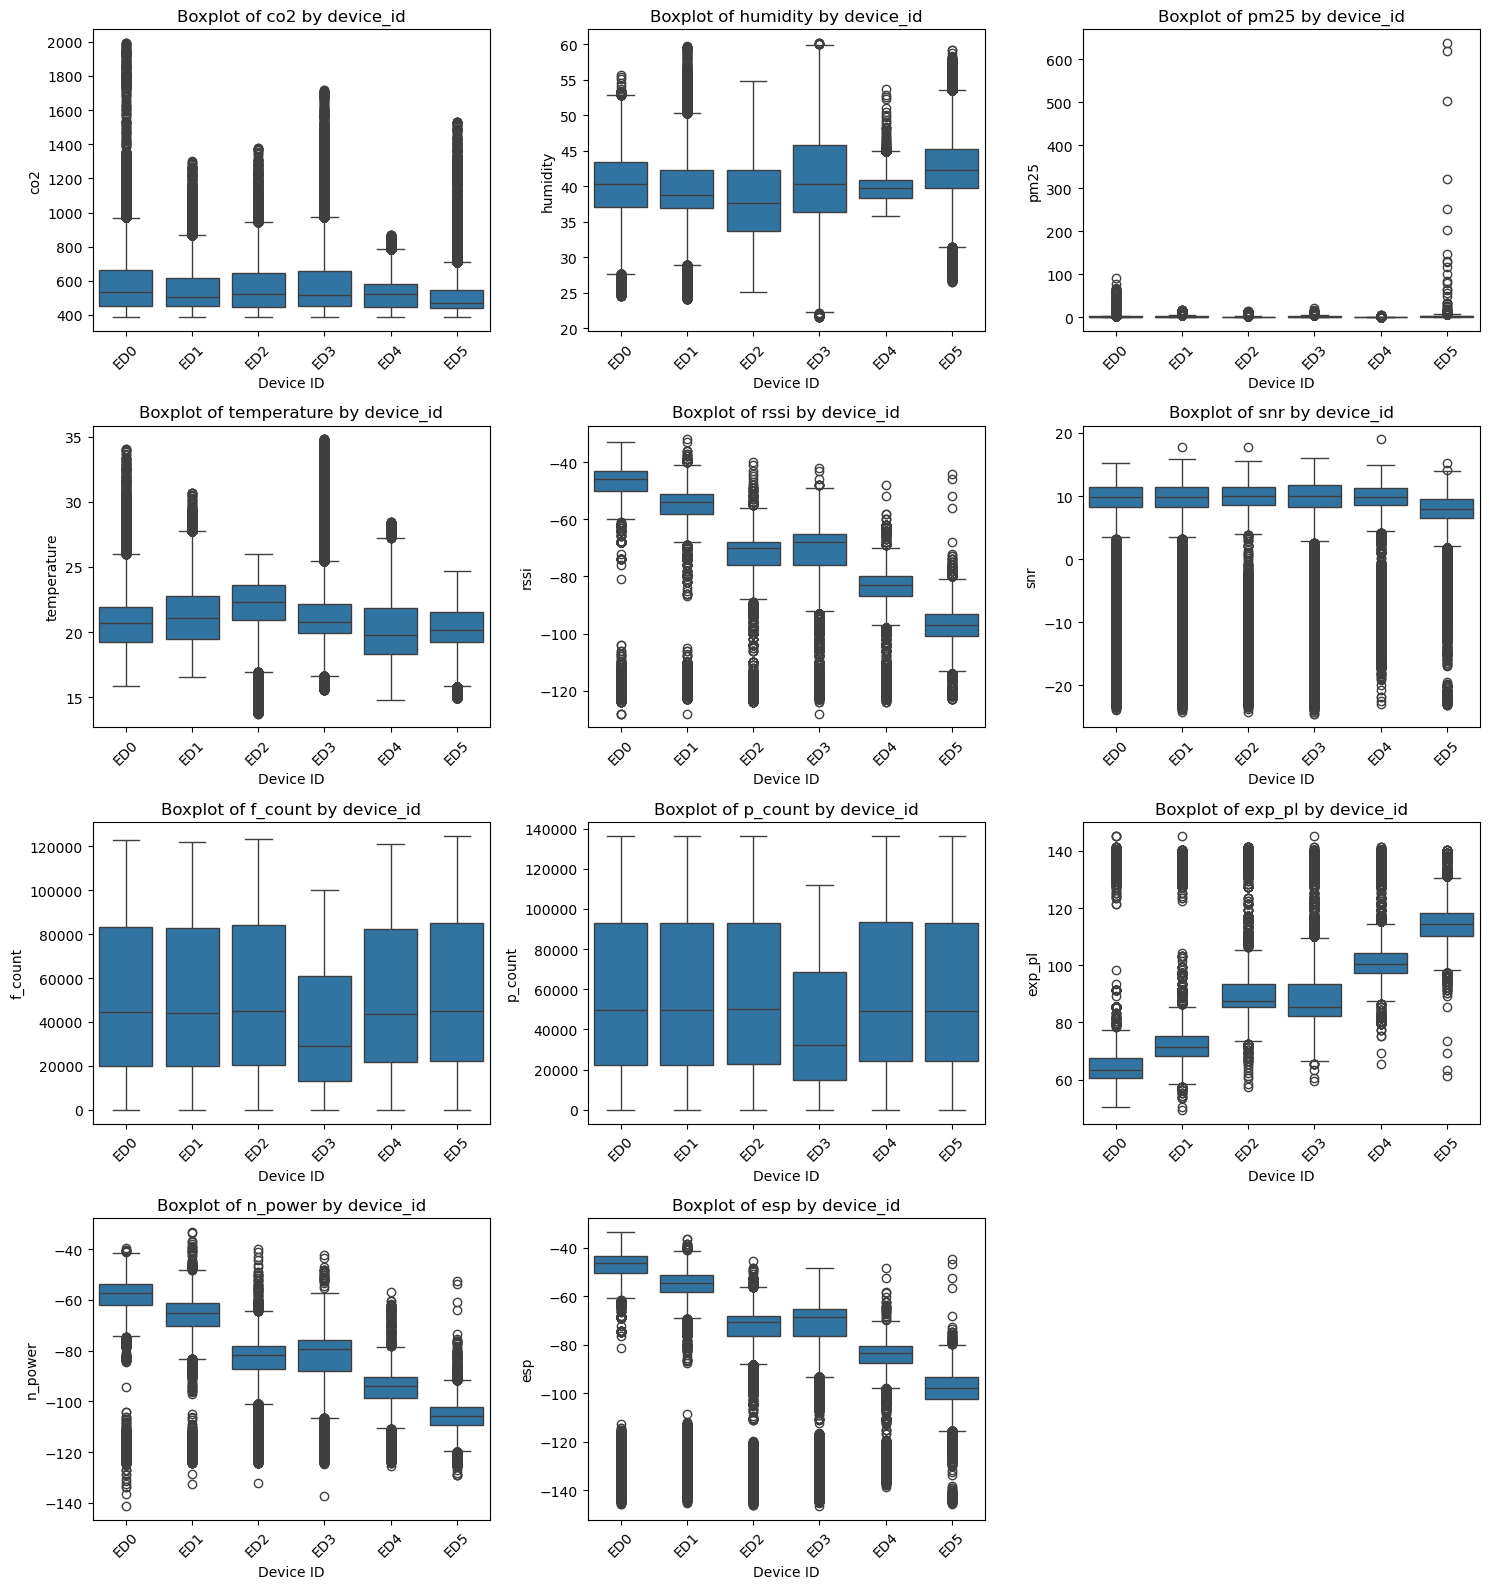

In [17]:
# Columns to exclude
exclude_cols = ['c_walls', 'w_walls', 'frequency', 'SF', 'toa', 'distance', 'pressure']

# Select numeric columns excluding 'f_count' and 'p_count'
numeric_cols = cleaned_df.select_dtypes(include=['float64', 'int64']).columns.drop(exclude_cols)

# Define the desired order for device_id
desired_order = ['ED0', 'ED1', 'ED2', 'ED3', 'ED4', 'ED5']

# Ensure 'device_id' is a categorical type with the specified order
cleaned_df.loc[:, 'device_id'] = pd.Categorical(cleaned_df['device_id'], categories=desired_order, ordered=True)

# Determine the number of plots
num_vars = len(numeric_cols)
cols = 3  # Number of columns in the subplot grid
rows = math.ceil(num_vars / cols)

# Set the overall figure size
plt.figure(figsize=(cols * 5, rows * 4))

# Iterate over each numeric column and create a subplot
for idx, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, cols, idx)
    sns.boxplot(x='device_id', y=col, data=cleaned_df, order=desired_order)
    plt.title(f'Boxplot of {col} by device_id')
    plt.xlabel('Device ID')
    plt.ylabel(col)
    plt.xticks(rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
  Plot for Some Dataframe variables over time
</p>

In [19]:
def plot_sensor_readings(cleaned_df, row_map):
    """
    Plots sensor readings by grouping devices and assigning colors dynamically.

    Args:
    - cleaned_df (DataFrame): Cleaned DataFrame containing sensor data.
    - row_map (dict): Mapping of sensor parameters to subplot rows.
    """
    # Create subplots dynamically based on the row_map provided
    fig = make_subplots(
        rows=len(row_map), cols=1, 
        subplot_titles=[f'{param.title()} Readings Over Time' for param in row_map]
    )

    # Define a pool of colors and create an iterator to cycle through them
    color_pool = itertools.cycle(['green', 'red', 'blue', 'purple', 'orange', 
                                  'cyan', 'magenta', 'brown', 'black', 'pink'])
    
    # Group by unique device IDs and assign colors dynamically
    device_colors = {device: next(color_pool) for device in cleaned_df['device_id'].unique()}

    # Set to track which devices have already been added to the legend
    devices_in_legend = set()

    # Plotting for each parameter and each device
    for param, row in row_map.items():
        for device, color in device_colors.items():
            # Filter data for the specific device
            data = cleaned_df[cleaned_df['device_id'] == device]
            
            # Add a trace for each parameter for the current device
            fig.add_trace(
                go.Scatter(
                    x=data['time'], 
                    y=data[param], 
                    mode='lines',  # Line plot
                    name=f"{device}" if device not in devices_in_legend else None,  # Device to legend once
                    line=dict(color=color),
                    showlegend=device not in devices_in_legend  # Show legend if the device hasn't been added yet
                ),
                row=row, col=1  # Place in the correct subplot
            )

            # Mark the device as added to the legend
            devices_in_legend.add(device)

    # Update layout with fixed height and other settings
    fig.update_layout(
        height=2400,  # Fixed height to accommodate all subplots
        showlegend=True,  # Show legend
        title_text="Sensor Readings Over Time",  # Overall plot title
        legend=dict(title="Devices", x=1.05, y=1)  # Adjusting legend position
    )

    # Show the plot
    fig.show()

# Example usage:
# Define the row mapping for parameters; can be modified as needed
row_map = {
    'temperature': 1, 'humidity': 2, 'co2': 3, 'pm25': 4, 
    'pressure': 5, 'rssi': 6, 'snr': 7, 'f_count': 8, 'p_count': 9
}

# Calling the function with the cleaned DataFrame and row_map
#plot_sensor_readings(cleaned_df, row_map)

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold;
color: blue;  text-align: left;">
  Statistical Description
</p>

In [21]:
# Generate statistical description and remove unnecessary columns
stat_description = cleaned_df.describe().transpose().drop(
    columns=['count']).drop(['f_count', 'p_count'])

# Define the exact order of metrics and units for alignment
metrics = [
    'co2', 'humidity', 'pm25', 'pressure', 'temperature', 
    'rssi', 'snr', 'SF', 'frequency', 'toa', 
    'distance', 'c_walls', 'w_walls', 'exp_pl', 'n_power', 'esp'
]
units = [
    'ppm', '%', 'µg/m³', 'hPa', '°C', 'dBm', 'dB', 'bit/sym', 'MHz', 's', 
    'm', '', '', 'dB', 'dB', 'dBm'
]

# Set index explicitly to ensure correct row order
stat_description = stat_description.loc[metrics]

# Add units as a separate column
stat_description.insert(0, 'Unit', units)

# Rename columns accordingly
stat_description = stat_description.rename(columns={
    'mean': 'Mean',
    'std': 'STD (σ)',
    'min': 'Min',
    '25%': '1ˢᵗ Quartile (25%)', 
    '50%': 'Median', 
    '75%': '3ʳᵈ Quartile (75%)',
    'max': 'Max'
})

# Add "Field" as a regular column to align with other columns
stat_description.reset_index(inplace=True)
stat_description = stat_description.rename(columns={'index': 'Field'})

# Remove the automatic index numbering in the output
stat_description.index = [''] * len(stat_description)

# Format floating-point numbers to 3 decimal places
pd.options.display.float_format = '{:.3f}'.format

# Save to Excel file without automatic indices
excel_path = "statistical_description.xlsx"
stat_description.to_excel(excel_path, index=False)

# Display the updated statistical description
stat_description

Field     Unit    Mean  STD (σ)      Min  1ˢᵗ Quartile (25%)  Median  \
          co2      ppm 551.059  135.991  386.000             448.000 507.000   
     humidity        %  40.304    5.325   21.550              37.170  40.020   
         pm25    µg/m³   1.621    2.152    0.000               0.560   1.080   
     pressure      hPa 323.301   11.143  286.910             315.960 324.650   
  temperature       °C  20.783    2.532   13.740              19.410  20.790   
         rssi      dBm -76.069   22.891 -128.000             -92.000 -72.000   
          snr       dB   7.644    6.897  -24.500               8.000   9.500   
           SF  bit/sym   9.322    1.685    7.000               8.000   9.000   
    frequency      MHz 867.830    0.461  867.100             867.500 867.900   
          toa        s   0.555    0.589    0.072               0.134   0.247   
     distance        m  22.740   12.292    8.000              10.000  23.000   
      c_walls            0.674    0.751    0.000               0.000   1.000   
      w_walls            1.827    1.664    0.000               0.000   2.000   
       exp_pl       dB  93.469   22.891   49.400              74.400  89.400   
      n_power       dB -85.312   20.602 -141.212            -101.871 -83.693   
          esp      dBm -77.668   25.302 -146.515             -92.667 -72.711   

  3ʳᵈ Quartile (75%)      Max  
             619.000 1993.000  
              43.410   60.190  
               2.050  637.710  
             332.210  347.570  
              22.250   34.800  
             -57.000  -32.000  
              11.200   19.000  
              11.000   12.000  
             868.300  868.500  
               0.987    1.974  
              37.000   40.000  
               1.000    2.000  
               2.000    5.000  
             109.400  145.400  
             -67.797  -33.146  
             -57.222  -33.493

<Figure size 2000x2000 with 0 Axes>

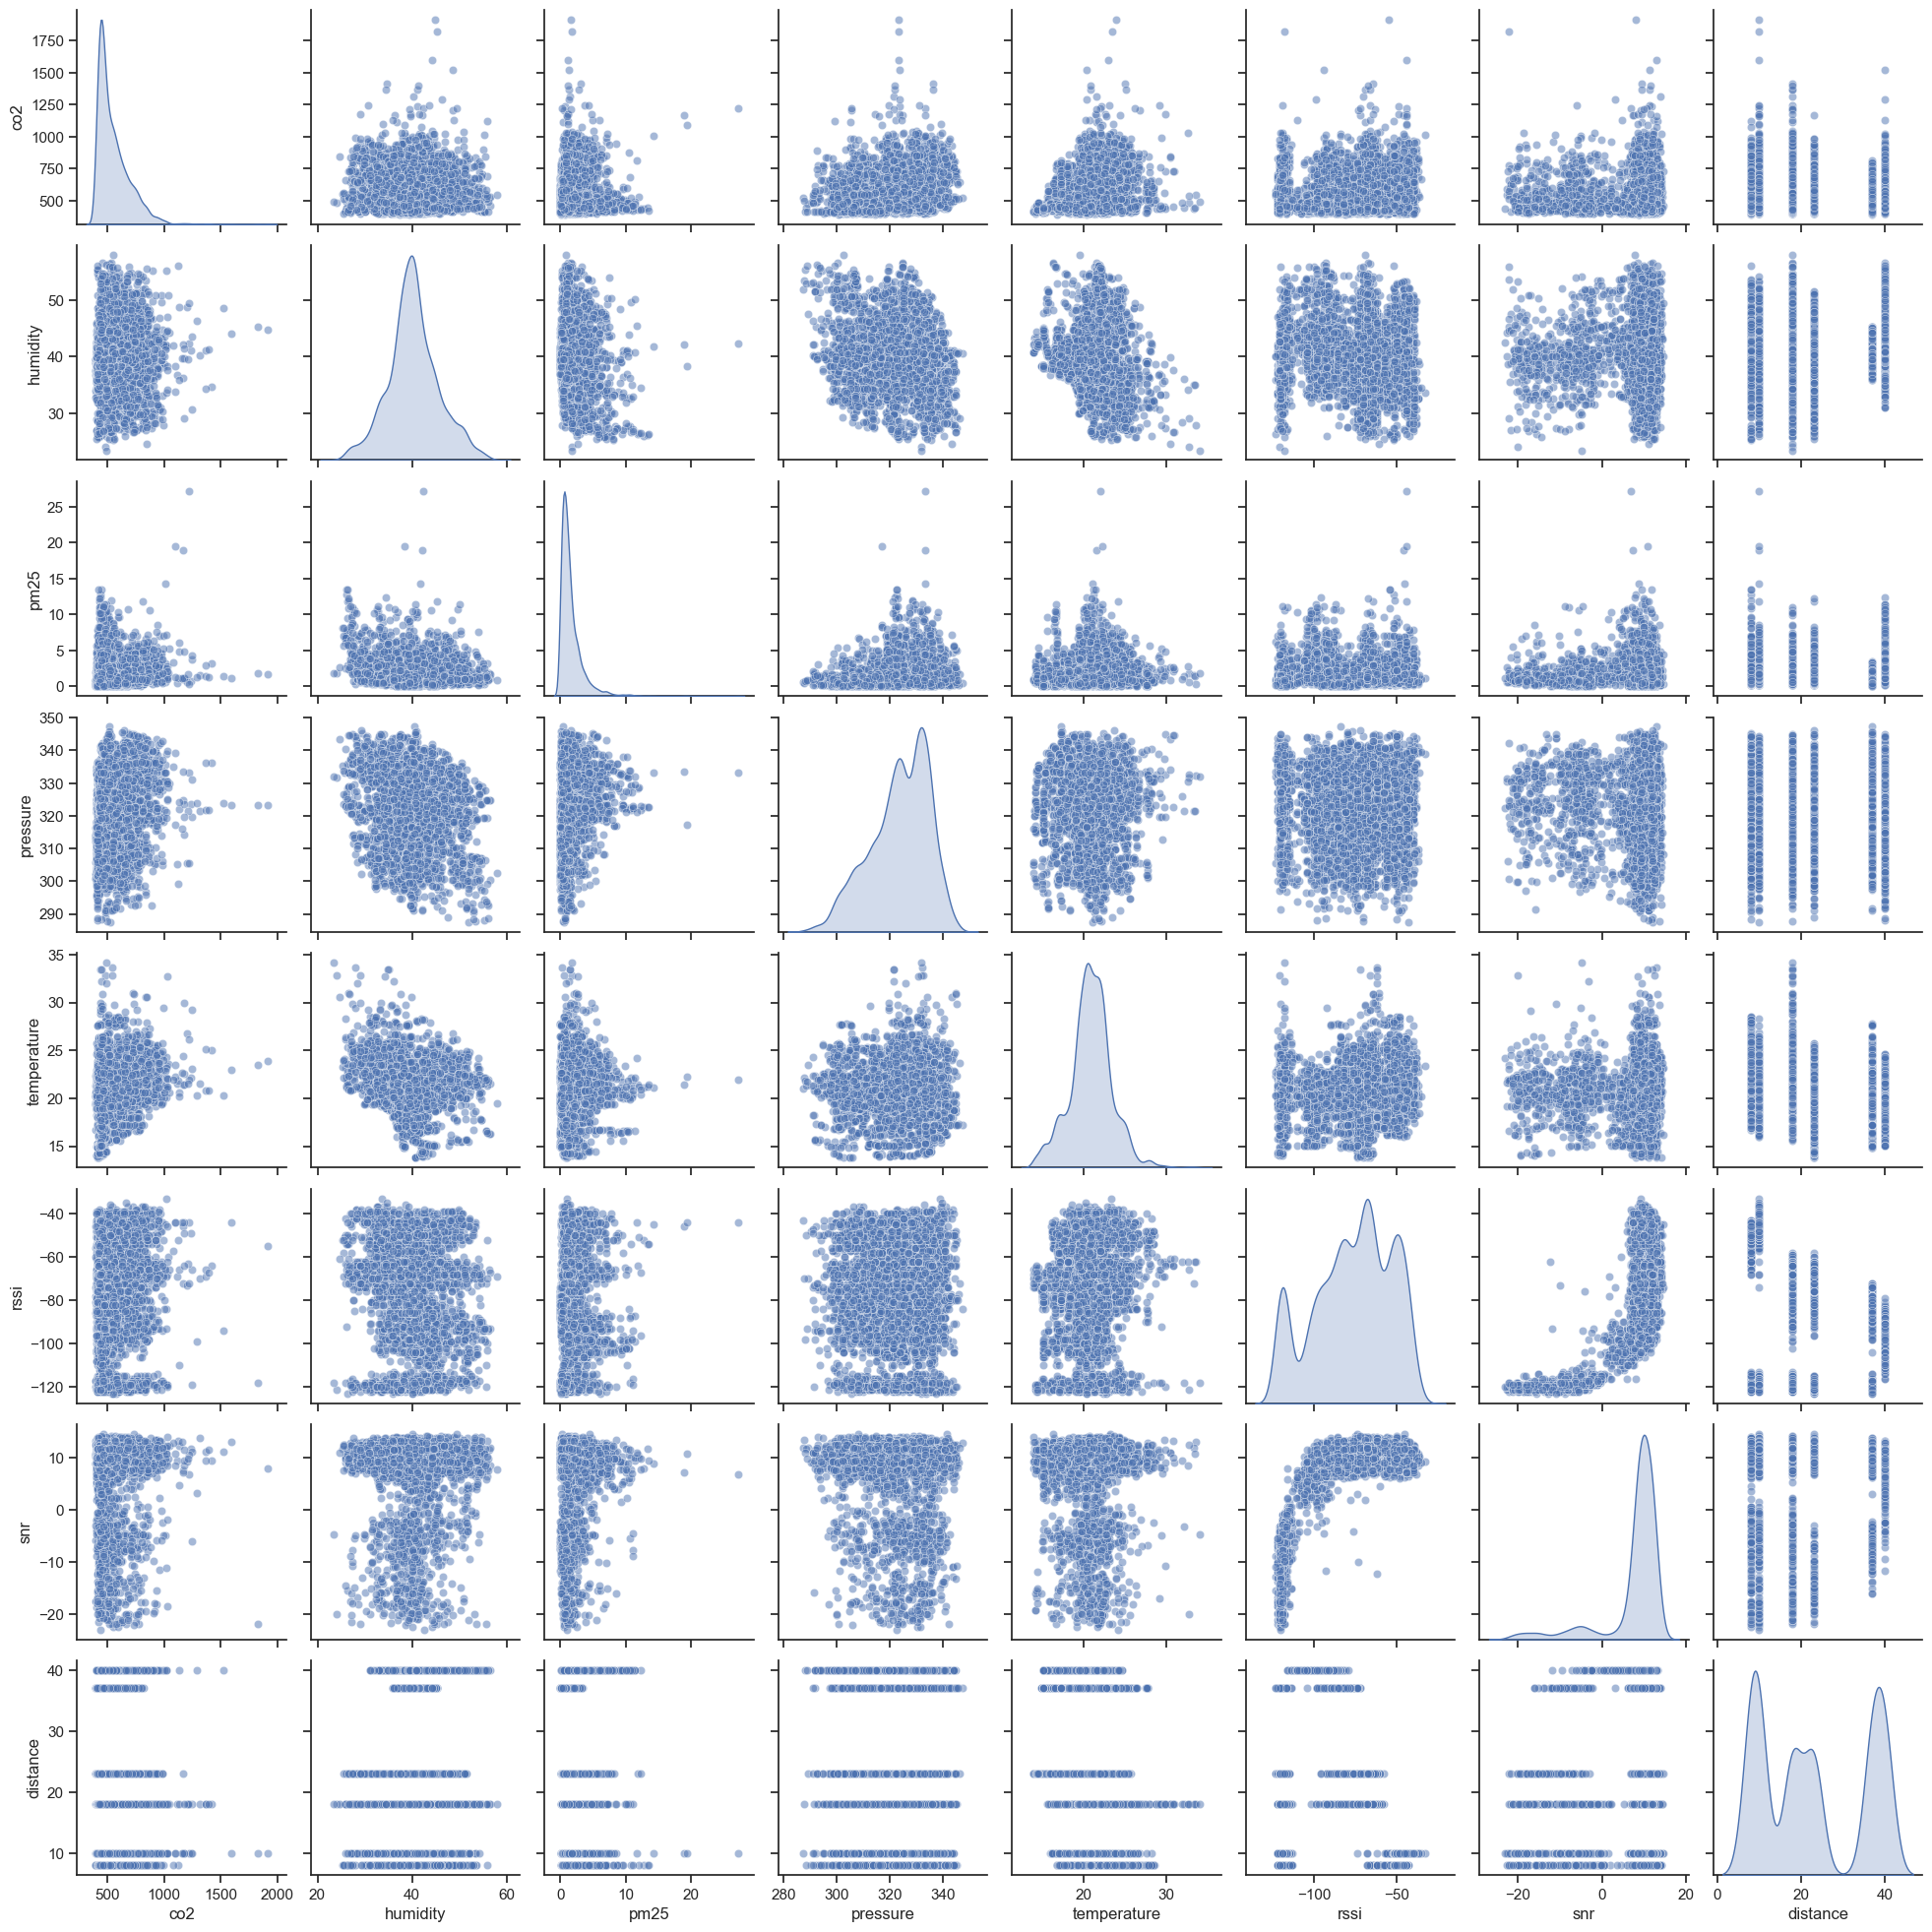

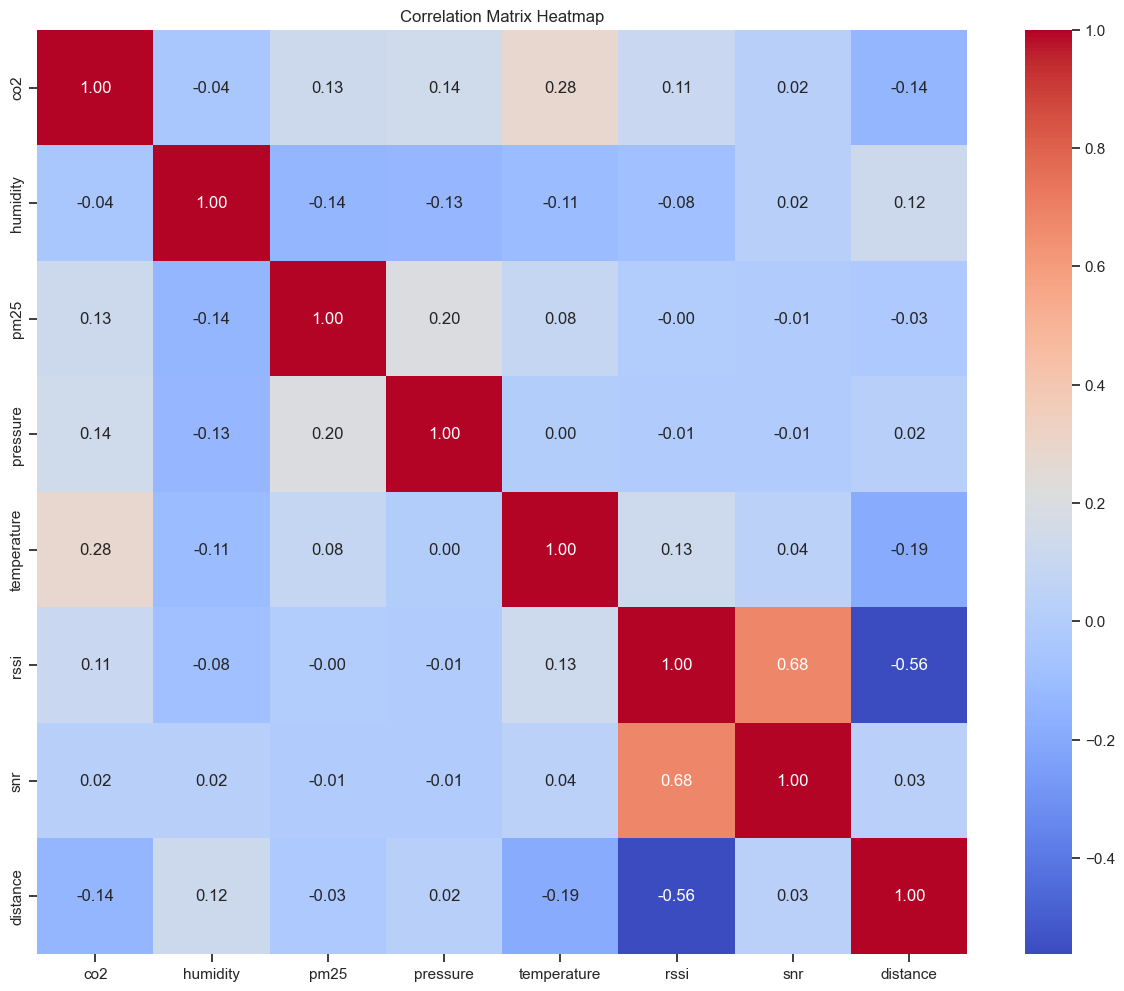

In [22]:
# Sample the DataFrame
sample_size = 5000
cleaned_df_sample = cleaned_df.sample(n=sample_size, random_state=42)

# Select Numerical Columns
numerical_cols = [
    'co2', 'humidity', 'pm25', 'pressure', 'temperature',
    'rssi', 'snr', 'distance'
]
numerical_cols = [col for col in numerical_cols if col in cleaned_df_sample.columns]
pairplot_df = cleaned_df_sample[numerical_cols]

# Create Pair Plot
sns.set(style="ticks", color_codes=True)
plt.figure(figsize=(20, 20))
pair_plot = sns.pairplot(pairplot_df, diag_kind='kde', plot_kws={'alpha': 0.5})
plt.show()

# Correlation Heatmap
corr_matrix = pairplot_df.corr()
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold;
color: blue;  text-align: left;">
  Overal Correlation Matrix
</p>

In [24]:
# Select only the numeric columns
numeric_df = cleaned_df.select_dtypes(include='number')

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Set the display format for floating-point numbers to xx decimal places
pd.options.display.float_format = '{:,.3f}'.format 

# Display the Correlation Matrix
correlation_matrix

co2  humidity   pm25  pressure  temperature   rssi    snr  \
co2          1.000    -0.045  0.099     0.147        0.280  0.100  0.013   
humidity    -0.045     1.000 -0.103    -0.130       -0.076 -0.081  0.010   
pm25         0.099    -0.103  1.000     0.172        0.081 -0.010 -0.015   
pressure     0.147    -0.130  0.172     1.000        0.011 -0.006  0.004   
temperature  0.280    -0.076  0.081     0.011        1.000  0.107  0.022   
rssi         0.100    -0.081 -0.010    -0.006        0.107  1.000  0.677   
snr          0.013     0.010 -0.015     0.004        0.022  0.677  1.000   
SF          -0.000     0.000  0.000     0.001       -0.002 -0.304 -0.393   
frequency   -0.001     0.001  0.001    -0.000       -0.001 -0.004 -0.071   
f_count      0.031    -0.507  0.045    -0.029       -0.481 -0.003 -0.017   
p_count      0.032    -0.509  0.040    -0.028       -0.482  0.000 -0.017   
toa         -0.000    -0.000 -0.001     0.000       -0.001 -0.373 -0.514   
distance    -0.130     0.113 -0.026     0.028       -0.180 -0.569  0.038   
c_walls     -0.074     0.205  0.251    -0.023       -0.055 -0.303 -0.019   
w_walls     -0.083     0.008 -0.199     0.050       -0.127 -0.425  0.042   
exp_pl      -0.100     0.081  0.010     0.006       -0.107 -1.000 -0.677   
n_power      0.105    -0.087 -0.005    -0.007        0.113  0.993  0.592   
esp          0.089    -0.068 -0.008    -0.005        0.098  0.993  0.754   

                SF  frequency  f_count  p_count    toa  distance  c_walls  \
co2         -0.000     -0.001    0.031    0.032 -0.000    -0.130   -0.074   
humidity     0.000      0.001   -0.507   -0.509 -0.000     0.113    0.205   
pm25         0.000      0.001    0.045    0.040 -0.001    -0.026    0.251   
pressure     0.001     -0.000   -0.029   -0.028  0.000     0.028   -0.023   
temperature -0.002     -0.001   -0.481   -0.482 -0.001    -0.180   -0.055   
rssi        -0.304     -0.004   -0.003    0.000 -0.373    -0.569   -0.303   
snr         -0.393     -0.071   -0.017   -0.017 -0.514     0.038   -0.019   
SF           1.000      0.077    0.003    0.003  0.907     0.001    0.003   
frequency    0.077      1.000    0.001    0.001  0.085     0.002    0.003   
f_count      0.003      0.001    1.000    1.000  0.002     0.040   -0.016   
p_count      0.003      0.001    1.000    1.000  0.002     0.035   -0.027   
toa          0.907      0.085    0.002    0.002  1.000    -0.001   -0.000   
distance     0.001      0.002    0.040    0.035 -0.001     1.000    0.294   
c_walls      0.003      0.003   -0.016   -0.027 -0.000     0.294    1.000   
w_walls     -0.002     -0.000   -0.004    0.001 -0.001     0.788   -0.171   
exp_pl       0.304      0.004    0.003   -0.000  0.373     0.569    0.303   
n_power     -0.275      0.013   -0.001    0.003 -0.328    -0.626   -0.320   
esp         -0.331     -0.009   -0.006   -0.003 -0.407    -0.499   -0.266   

             w_walls  exp_pl  n_power    esp  
co2           -0.083  -0.100    0.105  0.089  
humidity       0.008   0.081   -0.087 -0.068  
pm25          -0.199   0.010   -0.005 -0.008  
pressure       0.050   0.006   -0.007 -0.005  
temperature   -0.127  -0.107    0.113  0.098  
rssi          -0.425  -1.000    0.993  0.993  
snr            0.042  -0.677    0.592  0.754  
SF            -0.002   0.304   -0.275 -0.331  
frequency     -0.000   0.004    0.013 -0.009  
f_count       -0.004   0.003   -0.001 -0.006  
p_count        0.001  -0.000    0.003 -0.003  
toa           -0.001   0.373   -0.328 -0.407  
distance       0.788   0.569   -0.626 -0.499  
c_walls       -0.171   0.303   -0.320 -0.266  
w_walls        1.000   0.425   -0.475 -0.375  
exp_pl         0.425   1.000   -0.993 -0.993  
n_power       -0.475  -0.993    1.000  0.976  
esp           -0.375  -0.993    0.976  1.000

In [25]:
#Single out PL and sort the values
numeric_df.corr()['exp_pl'].sort_values()

rssi          -1.000
esp           -0.993
n_power       -0.993
snr           -0.677
temperature   -0.107
co2           -0.100
p_count       -0.000
f_count        0.003
frequency      0.004
pressure       0.006
pm25           0.010
humidity       0.081
c_walls        0.303
SF             0.304
toa            0.373
w_walls        0.425
distance       0.569
exp_pl         1.000
Name: exp_pl, dtype: float64

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 Scatter Plots : SNR vs RSSI for each Devices
</p>

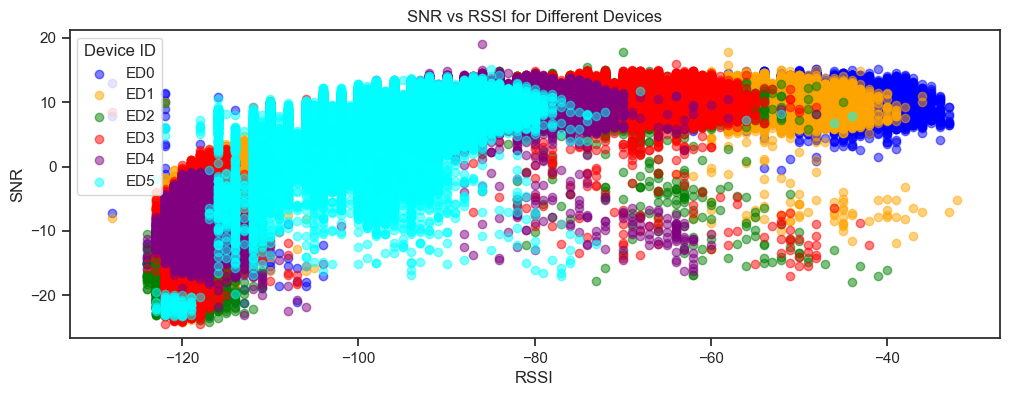

In [27]:
def plot_snr_vs_rssi(cleaned_df):
    """
    Plots SNR vs RSSI for each device dynamically using different colors.

    Args:
    - cleaned_df (DataFrame): Cleaned DataFrame containing sensor data with 'rssi' and 'snr' columns.
    """
    # Define a pool of colors and create an iterator to cycle through them
    color_pool = itertools.cycle(['blue', 'orange', 'green', 'red', 'purple', 
                                  'cyan', 'magenta', 'brown', 'black', 'pink'])

    # Create a figure for plotting
    plt.figure(figsize=(12, 4))

    # Group by unique device IDs and assign colors dynamically
    for device, color in zip(cleaned_df['device_id'].unique(), color_pool):
        # Filter data for each device
        subset = cleaned_df[cleaned_df['device_id'] == device]
        # Scatter plot for SNR vs RSSI
        plt.scatter(subset['rssi'], subset['snr'], label=device, color=color, alpha=0.5)

    # Add labels, legend, and title
    plt.xlabel('RSSI')
    plt.ylabel('SNR')
    plt.legend(title='Device ID', loc='upper left')
    plt.title('SNR vs RSSI for Different Devices')

    # Show the plot
    plt.show()

# Example usage:
plot_snr_vs_rssi(cleaned_df)

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 Exploration of LoRAWAN Parameters based on the Spreading Factor
</p>

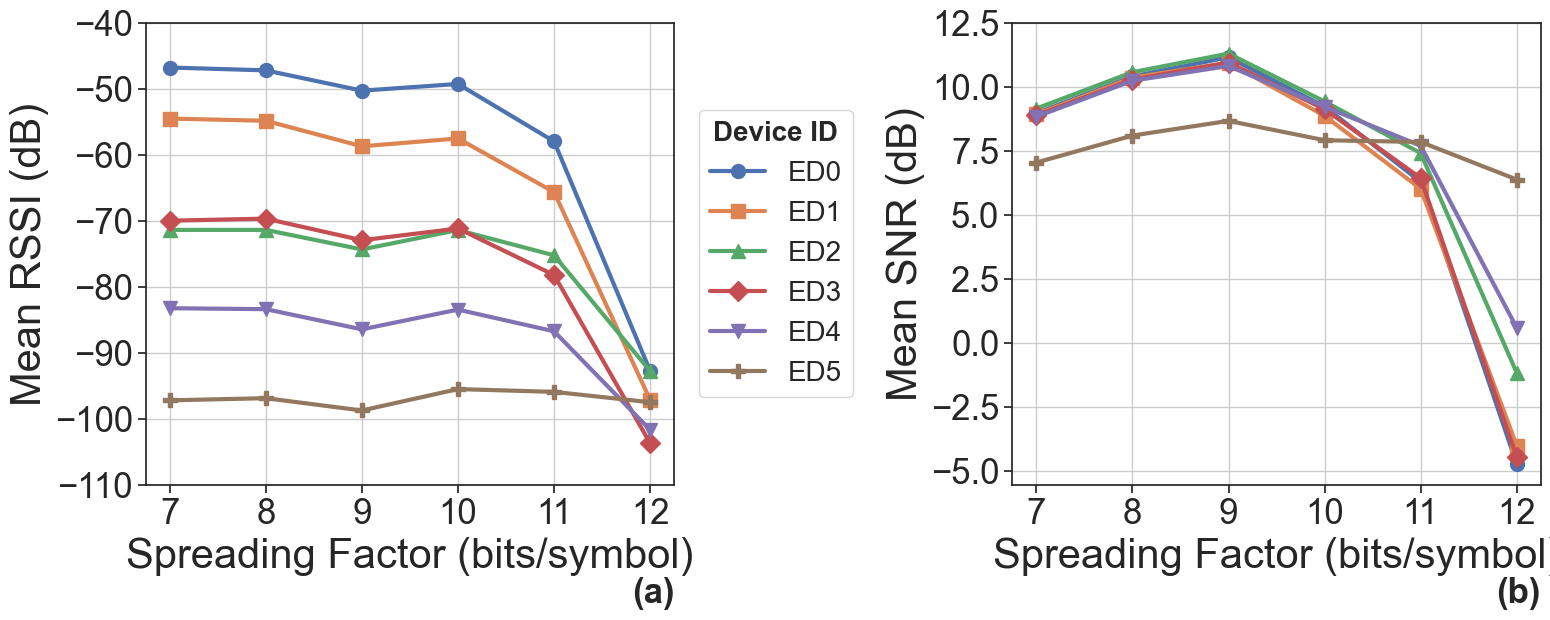

In [29]:
def plot_mean_metric(ax, cleaned_df, metric, ylabel, label=''):
    """
    Plots the mean of a specified metric grouped by Spreading Factor (SF) for each device.

    Args:
    - ax (Axes): Matplotlib Axes object to plot on.
    - cleaned_df (DataFrame): DataFrame containing sensor data with 'device_id', 'SF', and metric columns.
    - metric (str): The metric to plot (e.g., 'rssi', 'snr', 'toa').
    - ylabel (str): The label for the y-axis.
    - label (str): The subplot label (e.g., '(a)')
    """
    # Define a pool of markers to use for different devices
    marker_pool = itertools.cycle(['o', 's', '^', 'D', 'v', 'P', '*'])
    
    # Group by device and calculate mean metric for each SF
    for device_id, device_data in cleaned_df.groupby('device_id', observed=False):
        mean_metric = device_data.groupby('SF', observed=False)[metric].mean()
        # Plot mean metric for each device with a different marker
        ax.plot(mean_metric.index, mean_metric.values, marker=next(marker_pool), linestyle='-', markersize=10, linewidth=3, label=device_id)
    
    # Set axis labels with increased font size
    ax.set_xlabel('Spreading Factor (bits/symbol)', fontsize=30)
    ax.set_ylabel(ylabel, fontsize=30)
    ax.grid(True)
    
    # Set tick label font sizes
    ax.tick_params(axis='both', which='major', labelsize=25)
     
    # Set specific tick positions on the x-axis
    ax.set_xticks([7, 8, 9, 10, 11, 12]) 
    
    # Add subplot label (e.g., '(a)') with increased font size
    ax.text(1, -0.2, label, transform=ax.transAxes, fontsize=25, fontweight='bold', va='top', ha='right')

# Set up the matplotlib figure with GridSpec to allocate space for the legend
fig = plt.figure(figsize=(18, 6)) 

# Create a GridSpec with 1 row and 3 columns
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 0.2, 1], wspace=0.3)

# Add subplots for RSSI and SNR
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 2])



# Define subplot labels
subplot_labels = ['(a)', '(b)']

# Plot mean RSSI
plot_mean_metric(ax1, cleaned_df, 'rssi', 'Mean RSSI (dB)', label=subplot_labels[0])

# Plot mean SNR
plot_mean_metric(ax2, cleaned_df, 'snr', 'Mean SNR (dB)', label=subplot_labels[1])

# Collect handles and labels from both subplots
handles_a, labels_a = ax1.get_legend_handles_labels()
handles_b, labels_b = ax2.get_legend_handles_labels()

# Set specific tick positions on the y-axis
ax1.set_yticks([-110, -100, -90, -80, -70, -60, -50, -40])  
ax2.set_yticks([-5, -2.5, -0, 2.5, 5, 7.5, 10, 12.5]) 

# Combine handles and labels, ensuring uniqueness
unique = OrderedDict()
for label, handle in zip(labels_a + labels_b, handles_a + handles_b):
    if label not in unique:
        unique[label] = handle
handles, labels = unique.values(), unique.keys()

# Create a separate axis for the legend in the middle column
legend_ax = fig.add_subplot(gs[0, 1])
legend_ax.axis('off')  # Hide the axis

# Add the common legend to the legend axis
legend = legend_ax.legend(
    handles, labels, 
    title='Device ID', 
    fontsize=20, 
    title_fontsize=20, 
    loc='center left',  
    bbox_to_anchor=(-1.0, 0.5), 
    ncol=1
)

legend.get_title().set_fontweight('bold')

# Adjust layout to ensure everything fits without overlapping
# plt.tight_layout()

# Save the figure 
plt.savefig('../all_data_files/rssi_and_snr_per_SF.png', dpi=1000, bbox_inches='tight')

# Show the plot
plt.show()

In [30]:
# Calculate the mean of rssi, snr and exp_pl grouped by device_id
mean_values = cleaned_df.groupby('device_id', observed=False)[['rssi', 'snr', 'exp_pl']].mean()

# Display the mean values
mean_values

rssi   snr  exp_pl
device_id                      
ED0       -56.136 7.307  73.536
ED1       -63.480 7.298  80.880
ED2       -75.546 8.110  92.946
ED3       -76.675 7.288  94.075
ED4       -87.027 8.170 104.427
ED5       -97.008 7.691 114.408

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 KDE Plots: Environmental Parameters & LoRaWAN Signal PARAMETERS
</p>

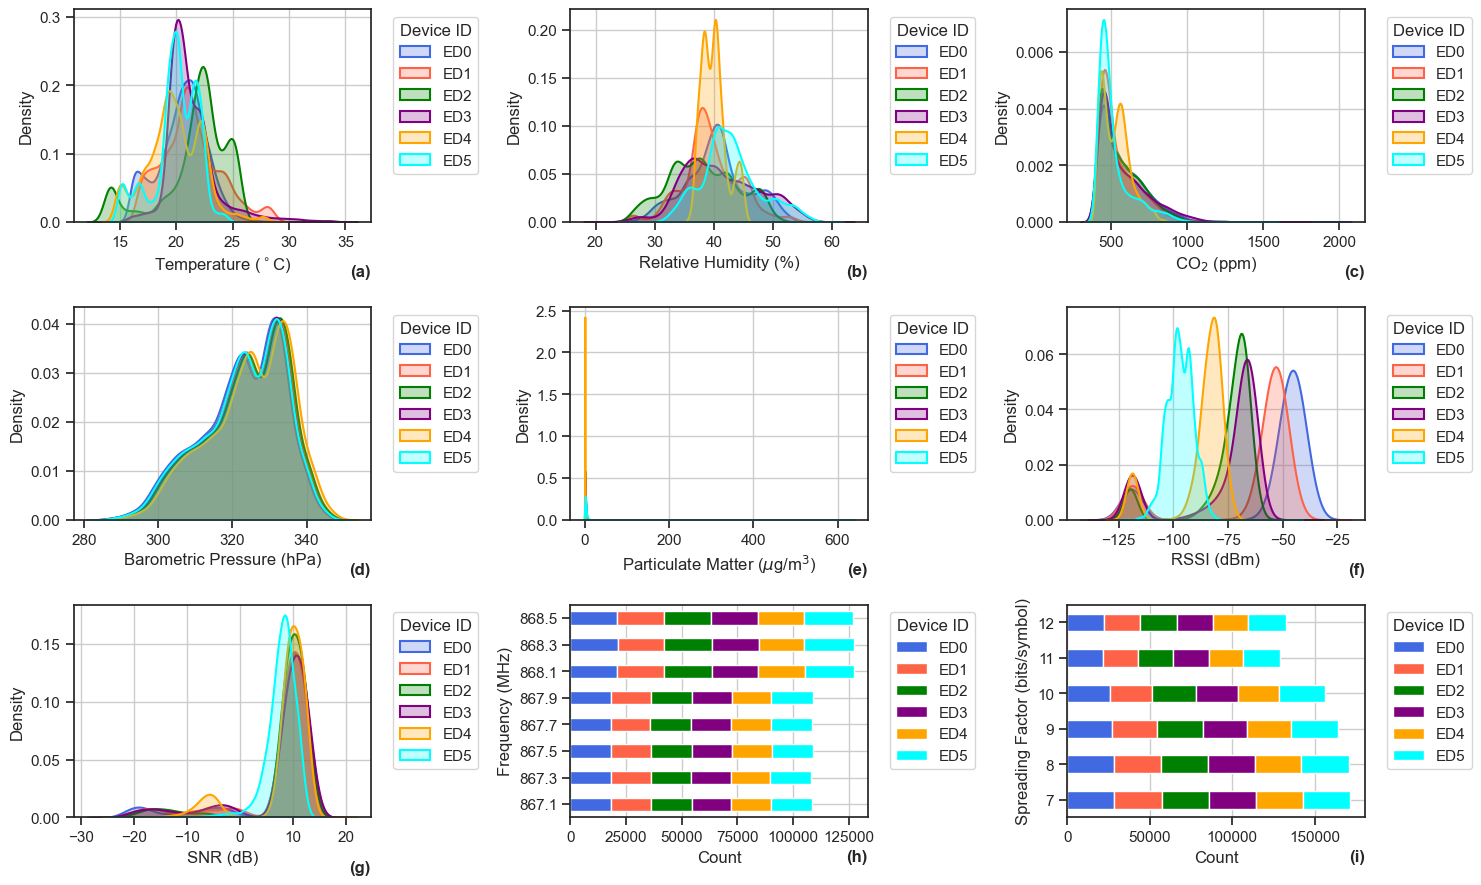

In [32]:
# Define labels with units and formatting
labels = {
    'temperature': 'Temperature ($^\circ$C)',
    'humidity': 'Relative Humidity (%)',
    'co2': 'CO$_2$ (ppm)',
    'pressure': 'Barometric Pressure (hPa)',
    'pm25': 'Particulate Matter ($\mu$g/m$^3$)',
    'rssi': 'RSSI (dBm)',
    'snr': 'SNR (dB)',
    'frequency': 'Frequency (MHz)',
    'SF': 'Spreading Factor (bits/symbol)'
}

def plot_stacked_bar(ax, data, parameter, label=''):
    """
    Plots a stacked bar chart for the given parameter, grouping by 'device_id'.

    Args:
    - ax (Axes): Matplotlib Axes object to plot on.
    - data (DataFrame): DataFrame containing sensor data with 'device_id' and the parameter to plot.
    - parameter (str): The parameter to plot (e.g., 'frequency', 'SF', 'distance').
    - label (str): The subplot label (e.g., '(a)')
    """
    # Define a pool of colors to use for different devices
    color_pool = itertools.cycle(['royalblue', 'tomato', 'green', 'purple', 'orange', 'cyan', 'magenta'])
    
    # Pivot the data to have device_id as columns
    pivot_data = data.pivot_table(index=parameter, columns='device_id', aggfunc='size', fill_value=0, observed=False)
    
    # Sort device_ids alphabetically
    device_ids = sorted(pivot_data.columns)
    
    # Create a color map dynamically based on sorted device_ids
    colors = {device: next(color_pool) for device in device_ids}

    # Plot the stacked bar plot
    pivot_data[device_ids].plot(kind='barh', stacked=True, ax=ax, color=[colors[device] for device in device_ids])
    
    ax.set_xlabel('Count')
    ax.set_ylabel(labels[parameter])
    ax.grid(True)
    
    # Sort the legend entries alphabetically
    handles, labels_ = ax.get_legend_handles_labels()
    sorted_labels, sorted_handles = zip(*sorted(zip(labels_, handles)))
    ax.legend(sorted_handles, sorted_labels, title='Device ID', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add subplot label
    ax.text(1, -0.15, label, transform=ax.transAxes, ha='right', va='top', fontweight='bold', fontsize=12)

def plot_kde(ax, data, parameter, bw_adjust=2, label=''):
    """
    Plots a Kernel Density Estimate (KDE) for the given parameter, grouped by 'device_id'.

    Args:
    - ax (Axes): Matplotlib Axes object to plot on.
    - data (DataFrame): DataFrame containing sensor data with 'device_id' and the parameter to plot.
    - parameter (str): The parameter to plot (e.g., 'temperature', 'humidity', 'co2').
    - bw_adjust (float): Bandwidth adjustment for the KDE plot.
    - label (str): The subplot label (e.g., '(a)')
    """
    # Define a pool of colours to use for different devices
    color_pool = itertools.cycle(['royalblue', 'tomato', 'green', 'purple', 'orange', 'cyan', 'magenta'])
    
    # Get sorted device_ids
    device_ids = sorted(data['device_id'].unique())
    
    # Create a color map dynamically based on sorted device_ids
    colors = {device_id: next(color_pool) for device_id in device_ids}
    
    # Plot KDE for each device, sorted by device_id
    for device_id in device_ids:
        subset = data[data['device_id'] == device_id]
        sns.kdeplot(
            subset[parameter], ax=ax, 
            label=device_id, 
            lw=1.5, 
            bw_adjust=bw_adjust, 
            fill=True, 
            color=colors[device_id]
        )
    
    ax.set_xlabel(labels[parameter])
    ax.set_ylabel('Density')
    ax.grid(True)
    
    # Sort the legend entries alphabetically
    handles, labels_ = ax.get_legend_handles_labels()
    sorted_labels, sorted_handles = zip(*sorted(zip(labels_, handles)))
    ax.legend(sorted_handles, sorted_labels, title='Device ID', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add subplot label
    ax.text(1, -0.2, label, transform=ax.transAxes, ha='right', va='top', fontweight='bold', fontsize=12)

# Filter the DataFrame
filtered_df = cleaned_df[cleaned_df['device_id'].isin(cleaned_df['device_id'].unique())]

# Set up the matplotlib figure with subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 9))  # Increased figure height for better spacing

# Define subplot labels
subplot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)']

# Plot each parameter on a separate subplot with corresponding labels
plot_kde(axes[0, 0], filtered_df, 'temperature', bw_adjust=2, label=subplot_labels[0])
plot_kde(axes[0, 1], filtered_df, 'humidity', bw_adjust=2, label=subplot_labels[1])
plot_kde(axes[0, 2], filtered_df, 'co2', bw_adjust=2, label=subplot_labels[2])
plot_kde(axes[1, 0], filtered_df, 'pressure', bw_adjust=2, label=subplot_labels[3])
plot_kde(axes[1, 1], filtered_df, 'pm25', bw_adjust=2, label=subplot_labels[4])
plot_kde(axes[1, 2], filtered_df, 'rssi', bw_adjust=2, label=subplot_labels[5])
plot_kde(axes[2, 0], filtered_df, 'snr', bw_adjust=2, label=subplot_labels[6])

# Plot the stacked bar charts on the last two subplots with corresponding labels
plot_stacked_bar(axes[2, 1], filtered_df, 'frequency', label=subplot_labels[7])
plot_stacked_bar(axes[2, 2], filtered_df, 'SF', label=subplot_labels[8])

# Ensure proper spacing between rows by adjusting the layout
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)  # Space between rows

# Save the figure
plt.savefig('../all_data_files/signal_environmental_dist.png', dpi=1000, bbox_inches='tight')

# Show the plot
plt.show()


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 LoRaWAN Effective Signal Power vs Noise Power
</p>

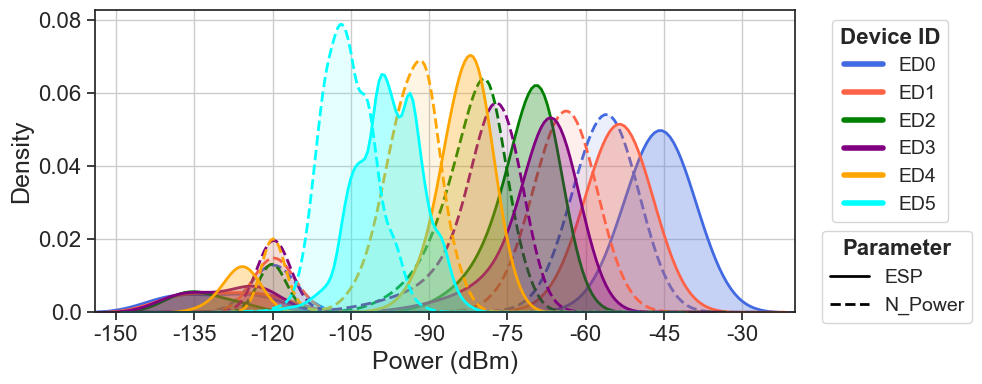

In [34]:
def plot_esp_n_power_comparison(ax, data, bw_adjust=2, title='ESP vs N_Power Distribution per Device'):
    """
    Compare 'esp' and 'n_power' distributions per device using KDE plots.
    'ESP' is dashed and 'N_Power' is solid.
    """
    # Assign colors to each device
    color_pool = cycle(['royalblue', 'tomato', 'green', 'purple', 'orange', 'cyan', 'magenta', 'brown', 'olive', 'pink'])
    devices = sorted(data['device_id'].unique())
    colors = {device: next(color_pool) for device in devices}
    
    for device in devices:
        subset = data[data['device_id'] == device]
        # Plot 'ESP' with solid line
        sns.kdeplot(
            subset['esp'], ax=ax, label=f'{device} - ESP', lw=2, bw_adjust=bw_adjust,
            linestyle='-', color=colors[device], fill=True, alpha=0.3
        )
        # Plot 'N_Power' with dashed line
        sns.kdeplot(
            subset['n_power'], ax=ax, label=f'{device} - N_Power', lw=2, bw_adjust=bw_adjust,
            linestyle='--', color=colors[device], fill=True, alpha=0.1
        )
    
    # Set titles and labels
    ax.set_xlabel('Power (dBm)', fontsize=18)  # Adjusted font size for x-axis label
    ax.set_ylabel('Density', fontsize=18)      # Adjusted font size for y-axis label
    ax.grid(True)

    # Set custom manual ticks
    ax.set_xticks(range(-150, -19, 15))  # Custom x-axis ticks from -150 to -20 with steps of 15
    ax.set_xticklabels(range(-150, -19, 15), fontsize=16)  # Font size for x-tick labels
    ax.set_yticks([0.0, 0.02, 0.04, 0.06, 0.08])  # Custom y-axis ticks
    ax.set_yticklabels(['0.0', '0.02', '0.04', '0.06', '0.08'], fontsize=16)  # Font size for y-tick labels
    
    # Add x-axis limits
    ax.set_xlim(-154, -20)
    
    # Create legends
    device_handles = [Line2D([0], [0], color=colors[device], lw=4) for device in devices]
    device_labels = devices
    parameter_handles = [
        Line2D([0], [0], color='black', lw=2, linestyle='-'),
        Line2D([0], [0], color='black', lw=2, linestyle='--')
    ]
    parameter_labels = ['ESP', 'N_Power']
    
    # Add device legend
    legend1 = ax.legend(
        device_handles, device_labels, title='Device ID',
        bbox_to_anchor=(1.04, 1), loc='upper left', fontsize=14, title_fontsize=16  # Font for legend
    )
    legend1.get_title().set_fontweight('bold') 
    ax.add_artist(legend1)
    
    # Add parameter legend
    legend2 = ax.legend(
        parameter_handles, parameter_labels, title='Parameter',
        bbox_to_anchor=(1.025, 0.3), loc='upper left', fontsize=14, title_fontsize=16  # Font for legend
    )
    legend2.get_title().set_fontweight('bold') 
    

# Plotting the comparison
fig, ax = plt.subplots(figsize=(10, 4))
plot_esp_n_power_comparison(ax, filtered_df, bw_adjust=2, title='ESP vs N_Power Distribution per Device')
plt.tight_layout()

# Save the plot
plt.savefig('../all_data_files/esp_n_power_comparison.png', dpi=1000)

# Display the plot
plt.show()

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 .....................#........................
</p>